In [1]:
import random
import time 
import os

import numpy as np
import pandas as pd
import seaborn as sn
from argparse import Namespace

import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForSequenceClassification, \
    get_linear_schedule_with_warmup, BertConfig

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
args = Namespace(
    dataset_dir = ".data",
    dataset_prefix = "faq_with_splits_",
    dataset = "lemmatized_filtered",
    models = ["SZTAKI-HLT/hubert-base-cc", "bert-base-multilingual-uncased"],
    model_save_dir = ".model_storage/BERT",
    model_state_file = "model",
    seed = 1234,
    num_epochs = 3,
    learning_rate = 5e-5,
    hidden_size = 100,
    batch_size = 16,
    cuda = True,
    train_column = ['short_question', 'long_question']
)

In [3]:
device = torch.device('cuda' if args.cuda & torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
args.model_state_file = os.path.join(args.model_save_dir, args.model_state_file)

In [5]:
if not os.path.exists(args.model_save_dir):
    os.makedirs(args.model_save_dir)
    print(f"Created directory {args.model_save_dir}")
else:
    print(f"{args.model_save_dir} directory already exists")

.model_storage/BERT directory already exists


In [6]:
args.dataset = os.path.join(args.dataset_dir, args.dataset_prefix + args.dataset)
print(args.dataset)

.data\faq_with_splits_lemmatized_filtered_mini


In [7]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

In [8]:
tokenizers = {}

for model in args.models:
    tokenizers[model] = BertTokenizerFast.from_pretrained(model)

In [9]:
df = pd.read_csv(args.dataset + '.csv')

In [10]:
df.head()

,short_question,long_question,answer,main_category,sub_category,split
0,van macska gazdi házi koszttal etet macsek mi ...,van macska gazdi házi koszttal etet macsek mi ...,Ez a két igen mire szól?,Állatok,Macskák,train
1,webfejlesztő android fejlesztő könnyű távmunka...,webfejlesztő android fejlesztő könnyű távmunka...,Miért lenne könyebb? A java könnyen tanulható...,Számítástechnika,Programozás,train
2,php programozás matek,php programozás matek szeret elkezd itthol tan...,"Ahhoz, hogy elkezdj PHP-tanulni, nem kell sok ...",Számítástechnika,Programozás,train
3,a diákmunka kér tüdőszűrés papír milyen orvos ...,a diákmunka kér tüdőszűrés papír milyen orvos ...,Nekem nem volt gond belőle hogy később lett,Egészség,Egészségügyi ellátások,train
4,a trónok harca mi pusztul valyria tud ez beteg...,a trónok harca mi pusztul valyria tud ez beteg...,"Senki sem tudja, mitől pusztult el Valyria. Mi...",Szórakozás,"Filmek, sorozatok",train


In [11]:
df = df[['main_category', *args.train_column, 'split']]

In [12]:
df.head()

,main_category,short_question,long_question,split
0,Állatok,van macska gazdi házi koszttal etet macsek mi ...,van macska gazdi házi koszttal etet macsek mi ...,train
1,Számítástechnika,webfejlesztő android fejlesztő könnyű távmunka...,webfejlesztő android fejlesztő könnyű távmunka...,train
2,Számítástechnika,php programozás matek,php programozás matek szeret elkezd itthol tan...,train
3,Egészség,a diákmunka kér tüdőszűrés papír milyen orvos ...,a diákmunka kér tüdőszűrés papír milyen orvos ...,train
4,Szórakozás,a trónok harca mi pusztul valyria tud ez beteg...,a trónok harca mi pusztul valyria tud ez beteg...,train


In [13]:
target_names = df.main_category.unique().tolist()
target_dict = {k: v for v, k in enumerate(target_names)}

print(target_names)
print(target_dict)

['Állatok', 'Számítástechnika', 'Egészség', 'Szórakozás']
{'Állatok': 0, 'Számítástechnika': 1, 'Egészség': 2, 'Szórakozás': 3}


In [14]:
df.main_category = df.main_category.apply(lambda x: target_dict[x])

In [15]:
max_seq_len = 128

In [16]:
def tokenize(df, tokenizer, train_column):
    return tokenizer.batch_encode_plus(
        df[train_column].tolist(),
        max_length = max_seq_len,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False
)

In [17]:
dfs = {}

for split in ['train', 'val', 'test']:
    dfs[split] = df[df.split == split]

In [18]:
encoded_data = {}

for model in args.models:
    tokenizer = tokenizers[model]

    encoded_data[model] = {}
    
    for train_column in args.train_column:
        encoded_data[model][train_column] = {}
        
        for split in ['train', 'val', 'test']:
            print(f"Encoding data for model '{model}' column '{train_column}' split '{split}'")
            encoded_data[model][train_column][split] = tokenize(dfs[split], tokenizer, train_column)

Encoding data for model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'train'
Encoding data for model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'val'
Encoding data for model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'test'
Encoding data for model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'train'
Encoding data for model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'val'
Encoding data for model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'test'
Encoding data for model 'bert-base-multilingual-uncased' column 'short_question' split 'train'
Encoding data for model 'bert-base-multilingual-uncased' column 'short_question' split 'val'
Encoding data for model 'bert-base-multilingual-uncased' column 'short_question' split 'test'
Encoding data for model 'bert-base-multilingual-uncased' column 'long_question' split 'train'
Encoding data for model 'bert-base-multilingual-uncased' column 'long_question' split 'val'
E

In [19]:
input_ids = {}
attention_masks = {}

for model in args.models:
    input_ids[model] = {}
    attention_masks[model] = {}
    
    for train_column in args.train_column:
        input_ids[model][train_column] = {}
        attention_masks[model][train_column] = {}
    
        for split in ['train', 'val', 'test']:
            input_ids[model][train_column][split] = encoded_data[model][train_column][split]['input_ids']
            attention_masks[model][train_column][split] = encoded_data[model][train_column][split]['attention_mask']

In [20]:
labels = {}

for split in ['train', 'val', 'test']:
    labels[split] = torch.tensor(dfs[split].main_category.values)

In [21]:
datasets = {}

for model in args.models:
    datasets[model] = {}
    
    for train_column in args.train_column:
        datasets[model][train_column] = {}

        for split in ['train', 'val', 'test']:
            print(f"Creating dataset for model '{model}' column '{train_column}' split '{split}'")
            datasets[model][train_column][split] = TensorDataset(
                            torch.tensor(input_ids[model][train_column][split]),
                            torch.tensor(attention_masks[model][train_column][split]),
                            labels[split]
            )

Creating dataset for model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'train'
Creating dataset for model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'val'
Creating dataset for model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'test'
Creating dataset for model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'train'
Creating dataset for model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'val'
Creating dataset for model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'test'
Creating dataset for model 'bert-base-multilingual-uncased' column 'short_question' split 'train'
Creating dataset for model 'bert-base-multilingual-uncased' column 'short_question' split 'val'
Creating dataset for model 'bert-base-multilingual-uncased' column 'short_question' split 'test'
Creating dataset for model 'bert-base-multilingual-uncased' column 'long_question' split 'train'
Creating dataset for model 'bert-base-multilingual-uncased' col

In [22]:
dataloaders = {}

for model in args.models:
    dataloaders[model] = {}
    
    for train_column in args.train_column:
        dataloaders[model][train_column] = {}

        for split in ['train', 'val', 'test']:
            print(f"Creating loader fro model '{model}' column '{train_column}' split '{split}'")
            dataloaders[model][train_column][split] = DataLoader(
                datasets[model][train_column][split],
                sampler=RandomSampler(datasets[model][train_column][split]),
                batch_size=args.batch_size
            )

Creating loader fro model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'train'
Creating loader fro model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'val'
Creating loader fro model 'SZTAKI-HLT/hubert-base-cc' column 'short_question' split 'test'
Creating loader fro model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'train'
Creating loader fro model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'val'
Creating loader fro model 'SZTAKI-HLT/hubert-base-cc' column 'long_question' split 'test'
Creating loader fro model 'bert-base-multilingual-uncased' column 'short_question' split 'train'
Creating loader fro model 'bert-base-multilingual-uncased' column 'short_question' split 'val'
Creating loader fro model 'bert-base-multilingual-uncased' column 'short_question' split 'test'
Creating loader fro model 'bert-base-multilingual-uncased' column 'long_question' split 'train'
Creating loader fro model 'bert-base-multilingual-uncased' column 'long_q

In [25]:
class_wts = compute_class_weight('balanced', np.unique(dfs['train'].main_category), \
                                 dfs['train'].main_category)

print(class_wts)

[1. 1. 1. 1.]


In [26]:
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

In [27]:
def class_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(y_true=labels_flat, y_pred=preds_flat)  

In [28]:
def show_data_to_model(model, optimizer, scheduler, criterion, bar, train):
    epoch_loss = 0
    epoch_acc = 0
       
    total_predicted = []
    true_vals = []
    idx = 0

    for batch in bar:
        idx += 1
        if train:
            optimizer.zero_grad()
            model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }
        
        outputs = model(**inputs)
        
        logits = outputs[1]
        label_ids = inputs['labels'].cpu().numpy()

        loss = criterion(logits, batch[2])
        logits = logits.detach().cpu().numpy()
        acc = class_accuracy(logits, label_ids)

        total_predicted += np.argmax(logits, axis=1).flatten().tolist()
        true_vals += label_ids.flatten().tolist()

        if train:
            loss.backward()
            optimizer.step()
            scheduler.step()

        del batch
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
        epoch_loss += loss.item()
        epoch_acc += acc.item()
       
        bar.set_postfix(loss=(epoch_loss / idx), acc=(epoch_acc / idx))

    return epoch_loss / idx , epoch_acc / idx, total_predicted, true_vals

In [29]:
def train_model(model, optimizer, scheduler, criterion, bar):
    model.train()
    loss, acc, _, _ = show_data_to_model(model, optimizer, scheduler, criterion, bar, True)
    
    return loss, acc

In [30]:
def evaluate_model(model, optimizer, scheduler, criterion, bar):
    model.eval()
    with torch.no_grad():
        loss, acc, pred, true_vals = show_data_to_model(model, optimizer, scheduler, criterion, bar, False)
            
    return loss, acc, pred, true_vals

In [31]:
from transformers import logging
logging.set_verbosity_error()

In [32]:
train_losses = {}
train_accuracies = {}

valid_losses = {}
valid_accuracies = {}

models = {}

for model_ in args.models:
    train_losses[model_] = {}
    train_accuracies[model_] = {}

    valid_losses[model_] = {}
    valid_accuracies[model_] = {}
    
    models[model_] = {} 
    
    for train_column in args.train_column:
        train_losses[model_][train_column] = []
        train_accuracies[model_][train_column] = []

        valid_losses[model_][train_column] = []
        valid_accuracies[model_][train_column] = []
        
        best_valid_loss = float('inf')
        
        train_dl = dataloaders[model_][train_column]['train']
        valid_dl = dataloaders[model_][train_column]['val']    
        
        model = BertForSequenceClassification.from_pretrained(
            model_,
            num_labels = len(target_names),
            output_attentions=False,
            output_hidden_states=False   
        )
        
        optimizer = AdamW(
            model.parameters(),
            args.learning_rate,
            eps=1e-8
        )
    
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_dl) * args.num_epochs
        )
    
        criterion = CrossEntropyLoss(weight=weights)
    
        model = model.to(device)
        criterion = criterion.to(device)
   
        epoch_bar = tqdm(desc=f"'{model_}' '{train_column}' epoch", total=args.num_epochs, position=0, leave=True)
        
        for epoch in range(args.num_epochs):
            train_bar = tqdm(train_dl, desc=f"'{model_}' '{train_column}' train", leave=False)
            valid_bar = tqdm(valid_dl, desc=f"'{model_}' '{train_column}' valid", leave=False)

            train_loss, train_acc = train_model(model, optimizer, scheduler, criterion, train_bar)
            valid_loss, valid_acc, _, _ = evaluate_model(model, optimizer, scheduler, criterion, valid_bar)

            train_losses[model_][train_column].append(train_loss)
            train_accuracies[model_][train_column].append(train_acc)

            valid_losses[model_][train_column].append(valid_loss)
            valid_accuracies[model_][train_column].append(valid_acc)
    
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss

                torch.save(model.state_dict(), args.model_state_file + \
                           "_" + model_.replace('/', '_') + \
                           '_' + train_column + ".pth")
 
            epoch_bar.update()
        models[model_][train_column] = model.to(torch.device('cpu'))

'SZTAKI-HLT/hubert-base-cc' 'short_question' epoch:   0%|          | 0/1 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' 'short_question' train:   0%|          | 0/263 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' 'short_question' valid:   0%|          | 0/57 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' 'long_question' epoch:   0%|          | 0/1 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' 'long_question' train:   0%|          | 0/263 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' 'long_question' valid:   0%|          | 0/57 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' 'short_question' epoch:   0%|          | 0/1 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' 'short_question' train:   0%|          | 0/263 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' 'short_question' valid:   0%|          | 0/57 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' 'long_question' epoch:   0%|          | 0/1 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' 'long_question' train:   0%|          | 0/263 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' 'long_question' valid:   0%|          | 0/57 [00:00<?, ?it/s]

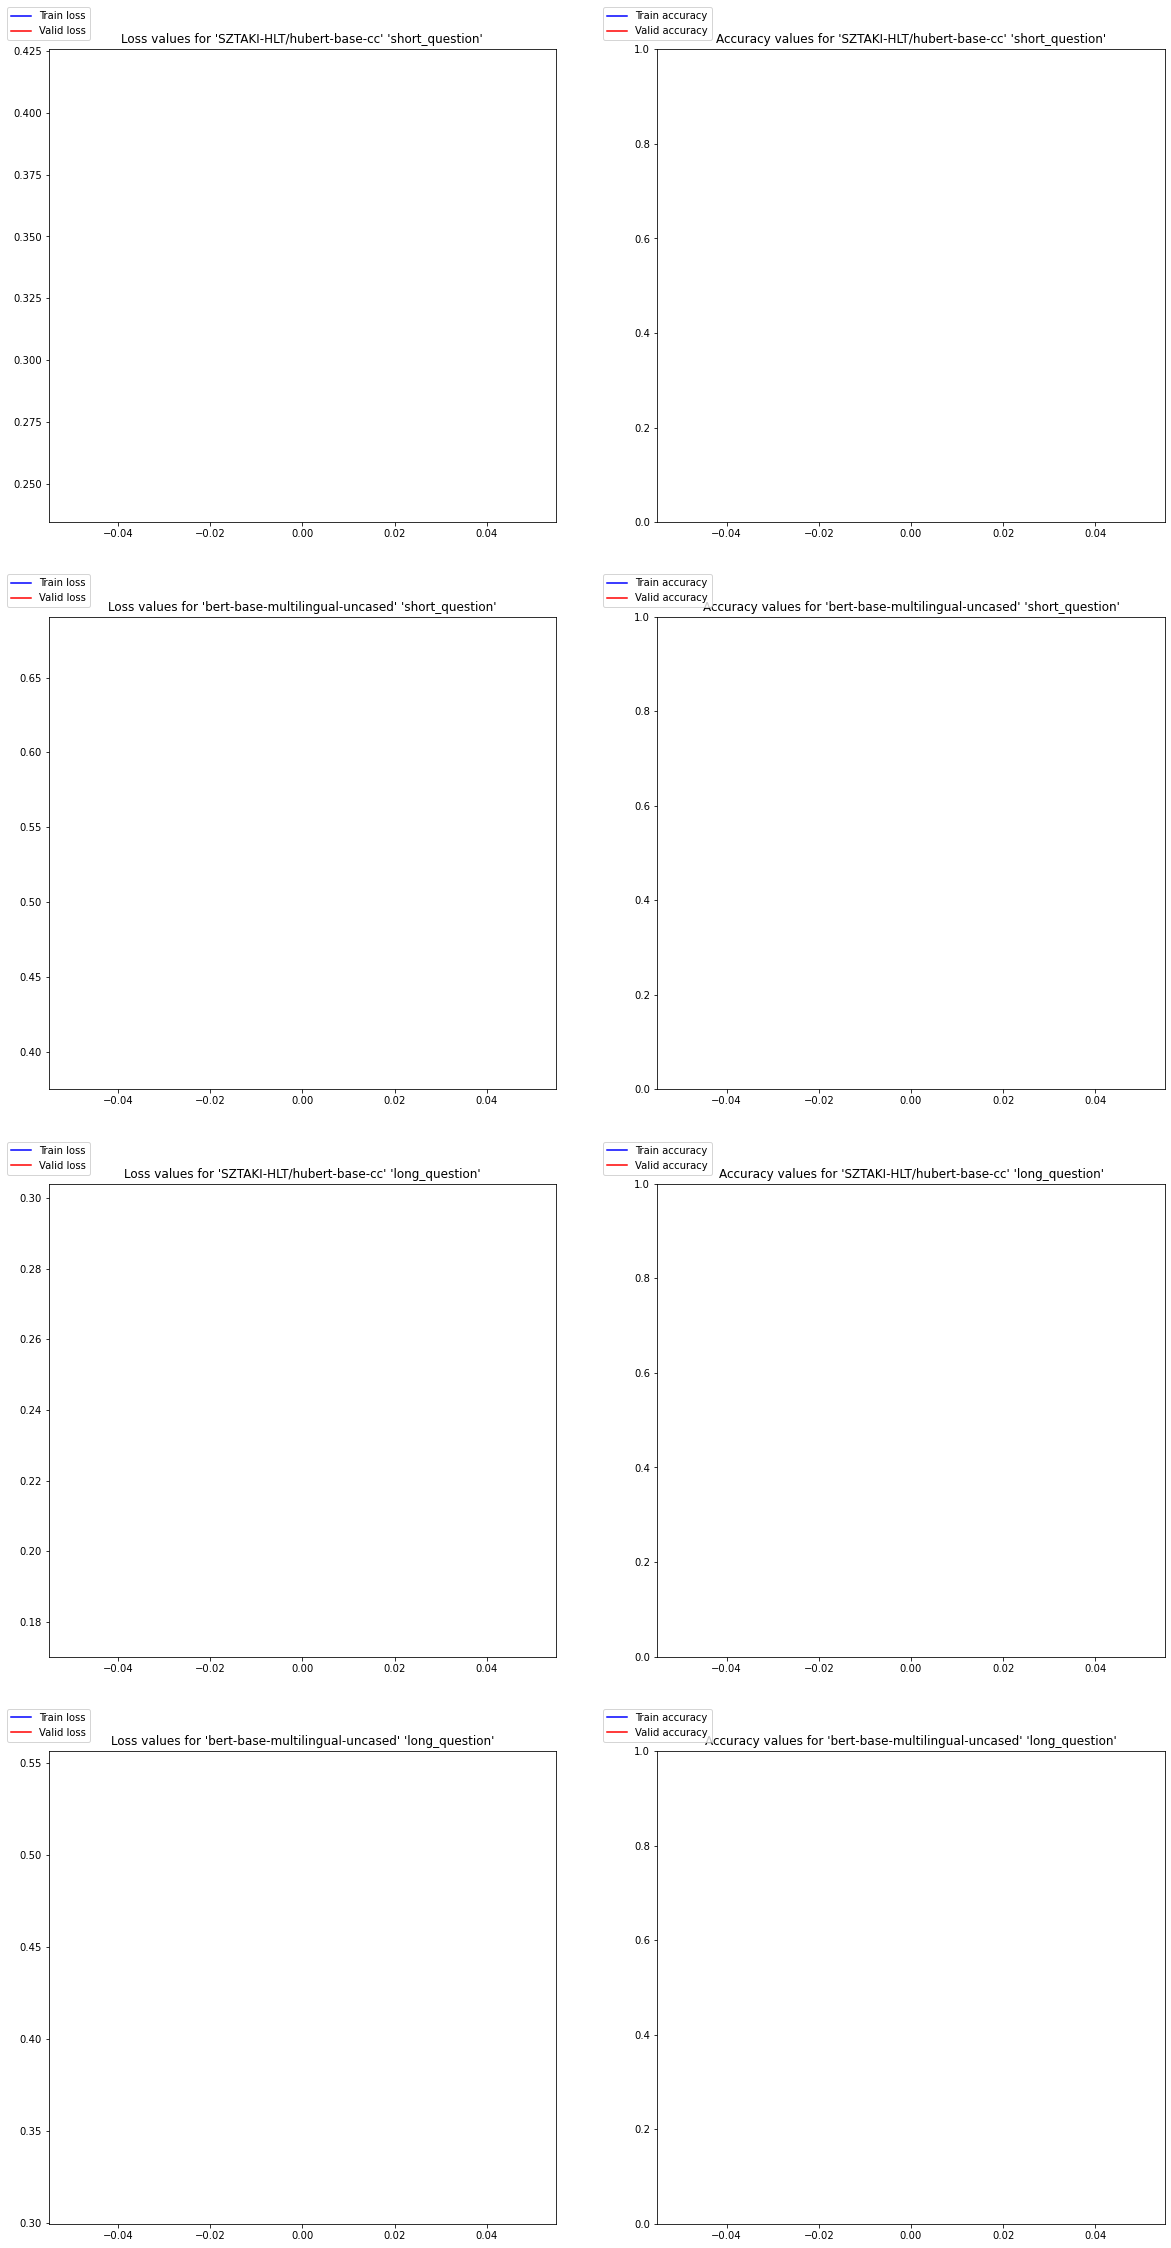

In [34]:
rows = len(args.models) * len(args.train_column)

fig, axs = plt.subplots(rows, 2, figsize=(10 * 2, 10 * rows))

for i, col in enumerate(args.train_column):
    for j, model_ in enumerate(args.models):
        idx = i * len(args.train_column) + j
        
        axs[idx, 0].set_title(f"Loss values for '{model_}' '{col}'")
        axs[idx, 0].plot([*range(args.num_epochs)], train_losses[model_][col], color = 'b', label='Train loss')
        axs[idx, 0].plot([*range(args.num_epochs)], valid_losses[model_][col], color = 'r', label='Valid loss')
        axs[idx, 0].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)

        axs[idx, 1].set_title(f"Accuracy values for '{model_}' '{col}'")
        axs[idx, 1].axis(ymin = 0, ymax = 1)
        axs[idx, 1].plot([*range(args.num_epochs)], train_accuracies[model_][col], color = 'b', label='Train accuracy')
        axs[idx, 1].plot([*range(args.num_epochs)], valid_accuracies[model_][col], color = 'r', label='Valid accuracy')
        axs[idx, 1].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
plt.show()

In [36]:
predictions = {}
test_target = {}

for model_ in args.models:
    test_target[model_] = {}
    predictions[model_] = {}

    config = BertConfig.from_pretrained(model_)
    config.num_labels = len(target_names)
    config.output_attentions = False
    config.output_hidden_states = False
    
    for train_column in args.train_column:

        
        test_dl = dataloaders[model_][train_column]['test']
    
        model = models[model_][train_column]
        model.load_state_dict(torch.load(args.model_state_file + \
                                         "_" + model_.replace('/', '_') + \
                                         '_' + train_column + ".pth"))

        criterion = CrossEntropyLoss(weight=weights)
    
        model = model.to(device)
        criterion = criterion.to(device)
    
        test_bar = tqdm(test_dl, desc=f"'{model_}' test", leave=False)

        _, _, predictions[model_][train_column], test_target[model_][train_column] = \
                    evaluate_model(model, None, None, criterion, test_bar)

        del model

'SZTAKI-HLT/hubert-base-cc' test:   0%|          | 0/57 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' test:   0%|          | 0/57 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' test:   0%|          | 0/57 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' test:   0%|          | 0/57 [00:00<?, ?it/s]

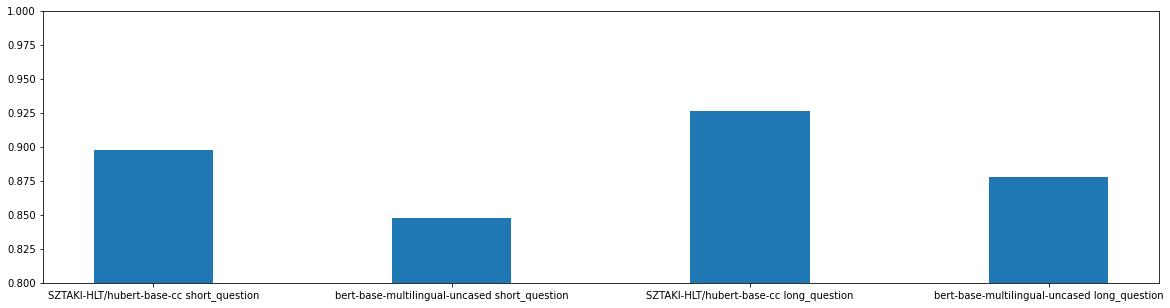

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

accuracy_scores = []
plot_labels = []

for train_column in args.train_column:
    for model_ in args.models:
        plot_labels.append(model_ + " " + train_column)
        
        prediction = predictions[model_][train_column]
        target = test_target[model_][train_column]
    
        accuracy_scores.append(accuracy_score(target, prediction))
    
ax.axis(ymin = 0.80, ymax = 1)
ax.bar(plot_labels, accuracy_scores, width=0.4)

plt.show()

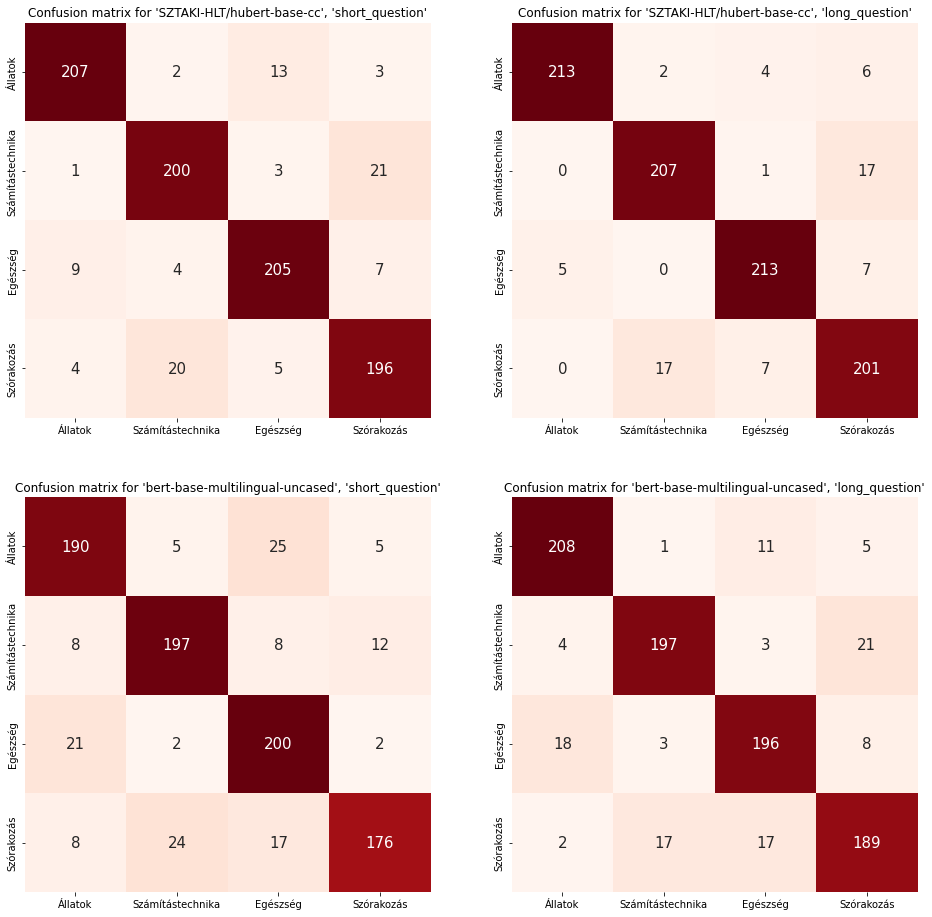

In [46]:
fig, axs = plt.subplots(len(args.models), len(args.train_column), figsize=(8 * len(args.train_column), 8 * len(args.models)))

for i, model_ in enumerate(args.models):
    for j, train_column in enumerate(args.train_column):
        axs[i, j].set_title(f"Confusion matrix for '{model_}', '{train_column}'")
    
        prediction = predictions[model_][train_column]
        target = test_target[model_][train_column]
        
        cm = confusion_matrix(target, prediction)
        cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    
        heatmap = sn.heatmap(cm_df, annot=True, ax=axs[i, j], cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)

plt.show()

In [47]:
for train_column in args.train_column:
    for model_ in args.models:
        prediction = predictions[model_][train_column]
        target = test_target[model_][train_column]
        
        report = classification_report(target, prediction, target_names=target_names)
        print(f"Classification report for '{model_}' '{train_column}':\n{report}\n{'=' * 60}")

Classification report for 'SZTAKI-HLT/hubert-base-cc' 'short_question':
                  precision    recall  f1-score   support

         Állatok       0.94      0.92      0.93       225
Számítástechnika       0.88      0.89      0.89       225
        Egészség       0.91      0.91      0.91       225
      Szórakozás       0.86      0.87      0.87       225

        accuracy                           0.90       900
       macro avg       0.90      0.90      0.90       900
    weighted avg       0.90      0.90      0.90       900

Classification report for 'bert-base-multilingual-uncased' 'short_question':
                  precision    recall  f1-score   support

         Állatok       0.84      0.84      0.84       225
Számítástechnika       0.86      0.88      0.87       225
        Egészség       0.80      0.89      0.84       225
      Szórakozás       0.90      0.78      0.84       225

        accuracy                           0.85       900
       macro avg       0.85      0